In [1]:
from stock_utils import *

In [2]:
df = pd.DataFrame()
df = df.from_csv('stock_data/spy.csv')
df = df.sort_index(axis=0)

daily_movements = get_price_movement_percentages(df)

In [3]:
def get_close_price(df):
    """ Get the simple moving average of a stock that's in a data frame. """
    df = df.sort_index(axis=0) ## We want the dates in ascending order
    close = np.zeros(len(df))

    for i in range(len(df)):
        close[i] = df['close'][i]

    return close

In [4]:
def get_sma(df, period_length):
    """ Get the simple moving average of a stock that's in a data frame. """
    #df = df.sort_index(axis=0) ## We want the dates in ascending order
    sma = np.zeros(len(df))
    sum_period = np.zeros(len(df))
    count = 0

    for i in range(len(df)):
        count = 0
        for j in range(period_length):
            if (i - j) >= 0:
                sum_period[i] += df[i - j]
                count += 1
        sma[i] = sum_period[i] / count
    return sma

In [5]:
close = get_close_price(df)
sma_20 = get_sma(df['close'], 20)
sma_50 = get_sma(df['close'], 50)
sma_100 = get_sma(df['close'], 100)

In [6]:
g = get_sma(df['close'], 4)
assert(int(g[0]) == int(df['close'][0]))
assert(int(g[1]) == int((df['close'][0] + df['close'][1]) / 2))
assert(int(g[2]) == int((df['close'][0] + df['close'][1] + df['close'][2]) / 3))
assert(int(g[3]) == int((df['close'][0] + df['close'][1] + df['close'][2] + df['close'][3]) / 4))
assert(int(g[4]) == int((df['close'][1] + df['close'][2] + df['close'][3] + df['close'][4]) / 4))

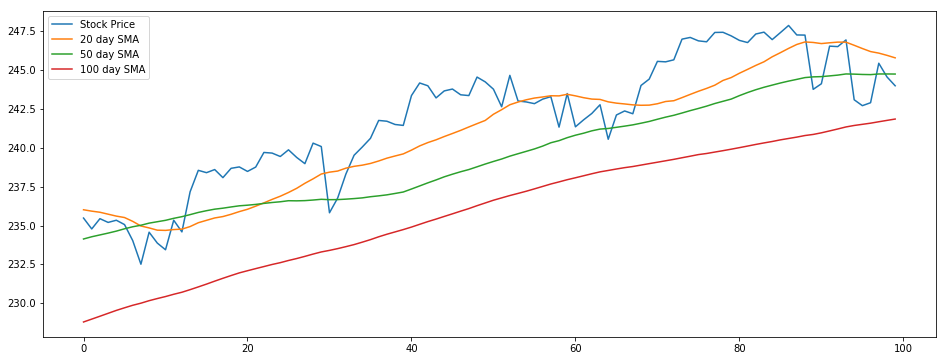

In [7]:
plt.figure(figsize=(16,6))
plt.plot(close[-100:], label='Stock Price')
plt.plot(sma_20[-100:], label='20 day SMA')
plt.plot(sma_50[-100:], label='50 day SMA')
plt.plot(sma_100[-100:], label='100 day SMA')
plt.legend()
plt.show()

In [8]:
def get_ema(df, period_length, alpha):
    """ Get the explonential moving average of a stock that's in a data frame. """
    #df = df.sort_index(axis=0) ## We want the dates in ascending order
    ema = np.zeros(len(df))
    sum_period = np.zeros(len(df))
    count = 0
    if not ( 0 <= alpha <= 1):
        raise ValueError('Alpha should be between 0 and 1')

    for i in range(len(df)):
        count = 0
        this_alpha = alpha
        for j in range(period_length):
            if (i - j) >= 0:
                sum_period[i] += df[i - j] * this_alpha
                count += this_alpha
                #print(this_alpha / alpha)
                this_alpha *= alpha
        ema[i] = sum_period[i] / count
    return ema

In [9]:
h = get_ema(df['close'], 4, 1)

In [10]:
assert(int(g[0]) == int(h[0]))
assert(int(g[1]) == int(h[1]))

In [11]:
alpha = 0.95
close = get_close_price(df)
ema_20 = get_ema(close, 20, alpha)
ema_50 = get_ema(close, 50, alpha)
ema_100 = get_ema(close, 100, alpha)

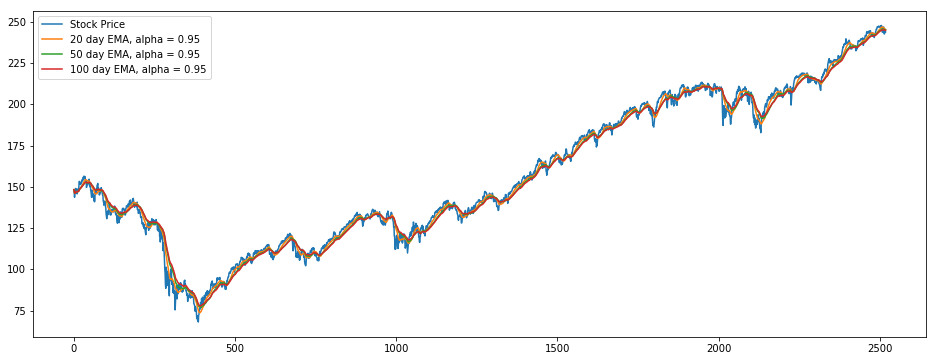

In [12]:
plt.figure(figsize=(16,6))
plt.plot(close, label='Stock Price')
plt.plot(ema_20, label='20 day EMA, alpha = ' + str(alpha))
plt.plot(ema_50, label='50 day EMA, alpha = ' + str(alpha))
plt.plot(ema_100, label='100 day EMA, alpha = ' + str(alpha))
plt.legend()
plt.show()

## MACD

In [15]:
def plot_macd(fast_period, slow_period, macd_ema_period, viewing_window, 
              alpha=0.95, show_ema=False, show_early_signals=False, show_macd_chart=True, 
              figsize=(16,6), ticker=None, threshold=0):    
    if ticker is None:
        close = get_close_price(df)
    else:
        df = pd.DataFrame()
        df = df.from_csv('stock_data/' + ticker.lower() +'.csv')
        df = df.sort_index(axis=0)
        close = get_close_price(df)
    fast_leg = get_ema(close, fast_period, alpha)
    slow_leg = get_ema(close, slow_period, alpha)
    macd = fast_leg - slow_leg
    macd_signal = get_ema(macd, macd_ema_period, alpha)
    macd_diff = macd - macd_signal
    
    zero_line = np.zeros(len(macd))
    
    buy_signals = []
    sell_signals = []
    early_buy_signals = []
    early_sell_signals = []

    for i in range(len(macd_diff) - 1):
        if macd_diff[i] < threshold and macd_diff[i+1] > threshold:
            buy_signals.append((i, close[i]))
        elif macd_diff[i] > -threshold and macd_diff[i+1] < -threshold:
            sell_signals.append((i, close[i]))
            
    for i in range(len(macd_diff) - 1):
        if macd_diff[i] < 0 and  macd_diff[i] < macd_diff[i+1]:
            early_buy_signals.append((i, close[i]))
        elif macd_diff[i] > 0 and macd_diff[i] > macd_diff[i+1]:
            early_sell_signals.append((i, close[i]))
    
    plt.figure(figsize=figsize)
    plt.plot(close[-viewing_window:], label='Stock Price')
    if show_ema:
        plt.plot(fast_leg[-viewing_window:], label='Fast EMA')
        plt.plot(slow_leg[-viewing_window:], label='Slow EMA')
        
    plt.title('Stock Price and Signals')
    
    if show_early_signals:
        for i in range(len(early_buy_signals)):
            if early_buy_signals[i][0] > len(macd) - viewing_window:
                plt.scatter(early_buy_signals[i][0] - (len(macd) - viewing_window), early_buy_signals[i][1], c='#8fba80')
        for i in range(len(early_sell_signals)):
            if early_sell_signals[i][0] > len(macd) - viewing_window:
                plt.scatter(early_sell_signals[i][0] - (len(macd) - viewing_window), early_sell_signals[i][1], c='#c19b95')##c1897f
    
    for i in range(len(buy_signals)):
        if buy_signals[i][0] > len(macd) - viewing_window:
            plt.scatter(buy_signals[i][0] - (len(macd) - viewing_window), buy_signals[i][1], c='green')
    for i in range(len(sell_signals)):
        if sell_signals[i][0] > len(macd) - viewing_window:
            plt.scatter(sell_signals[i][0] - (len(macd) - viewing_window), sell_signals[i][1], c='red')
        
    plt.legend()
    
    ## MACD
    if show_macd_chart:
        plt.figure(figsize=figsize)
        plt.plot(zero_line[-viewing_window:], c='black')
        plt.plot(macd[-viewing_window:], label='MACD', c='blue')
        plt.plot(macd_signal[-viewing_window:], label='MACD Signal Line', c='green')
        plt.plot(macd_diff[-viewing_window:], label='MACD Difference', c='red', linestyle='dashed')
        plt.title('MACD')
        plt.legend()
    plt.show()

In [18]:
#plot_macd(2, 4, 2, 100, ticker='FB', show_early_signals=True, threshold=0.1, show_ema=True)

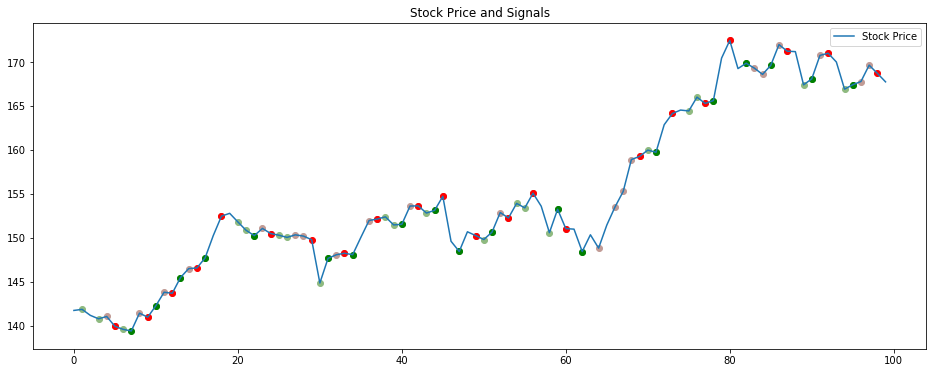

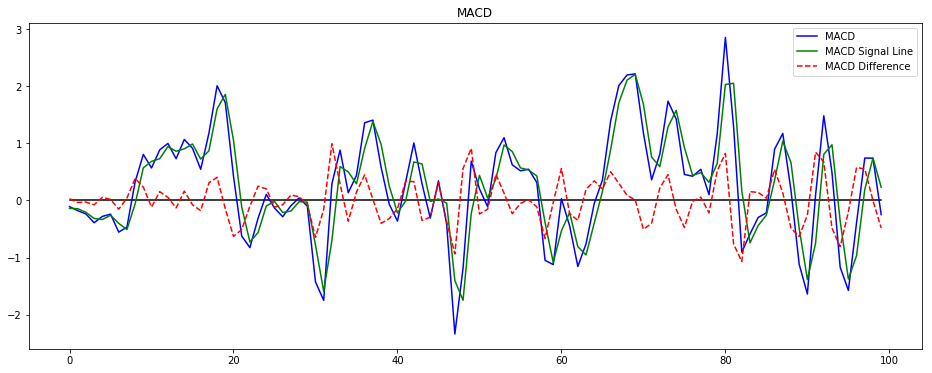

In [19]:
plot_macd(2, 4, 2, 100, ticker='FB', show_early_signals=True, threshold=0.1)

#### 2-4-2 seems to work well